# Esercitazione lab 9

## Problema di Regressione

<font color = 'yellow'> Per un problema di **regressione**: </font>
1. Confrontare le prestazioni (accuratezza) di
    + `GaussianNB`
    + `RidgeClassifier`
    + `Gaussian Mixture Models` \
      con e senza PCA. _(I modelli andranno a classificare gli esempi sullo spazio ottenuto da PCA.)_
2. Visualizzare i grafici ottenuti per tutti gli embedding su `sklearn`.
3. Confrontiamo anche in modo quantitativo il risultato in base all'accuracy.

## Carico il dataset `california`

In [4]:
from sklearn.datasets import fetch_california_housing

In [8]:
import inspect
inspect.signature(fetch_california_housing)

<Signature (*, data_home=None, download_if_missing=True, return_X_y=False, as_frame=False, n_retries=3, delay=1.0)>

In [10]:
housing = fetch_california_housing()
X, y = fetch_california_housing(return_X_y= True)

In [11]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

# Comparing PCA

## Pipeline: Scaling + PCA

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
pipeline = make_pipeline(StandardScaler(), PCA(n_components = 2))

X_transformed= pipeline.fit_transform(X)

display(f"Original shape: {X.shape}")
display(f"Transformed shape: {X_transformed.shape}")

'Original shape: (20640, 8)'

'Transformed shape: (20640, 2)'

## Visualize PCA

In [14]:
import numpy as np
import matplotlib.pyplot as plt

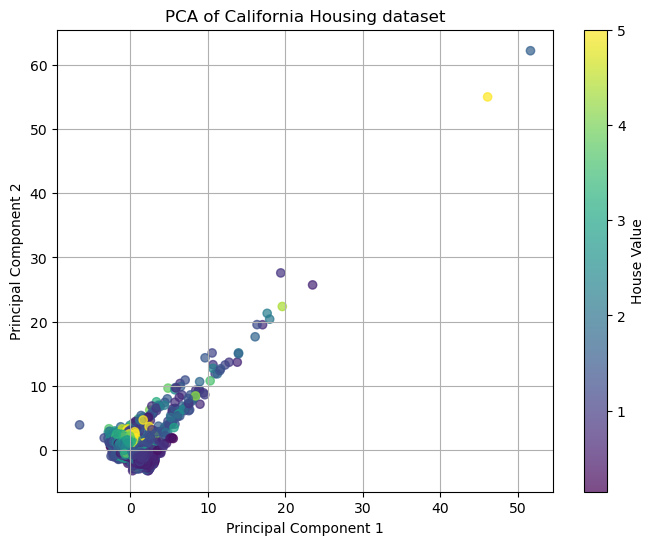

In [15]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], 
                 c=y, cmap='viridis', alpha=0.7)

plt.title("PCA of California Housing dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(sc, label="House Value")
plt.grid(True)
plt.show()

## k-fold function [Regression]

In [16]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def evaluate_with_kfold(model, X, y, n_splits=3):
    if len(X) != len(y):
        print(f"Error: Mismatched lengths - X: {len(X)}, y: {len(y)}")
        return None

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    try:
        # RMSE scores
        mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-mse_scores)

        # R² scores
        r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

        mean_rmse = np.mean(rmse_scores)
        std_rmse = np.std(rmse_scores)
        mean_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)

        print(f"Mean RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
        print(f"Mean R²: {mean_r2:.4f} ± {std_r2:.4f}")

        # Return both mean R² and standard deviation
        return mean_r2, std_r2
    except ValueError as e:
        print(f"Error during cross-validation: {e}")
        return None

## Ridge Regressor

In [20]:
import time
from sklearn.linear_model import Ridge

In [21]:
rr = Ridge(random_state= 42)

In [22]:
start_time = time.time()

display("Original X:")
evaluate_with_kfold(rr, X, y)

display("Transformed X:")
evaluate_with_kfold(rr, X_transformed, y)

end_time = time.time()

display("Execution time:",end_time - start_time)

'Original X:'

Mean RMSE: 0.7265 ± 0.0062
Mean R²: 0.6035 ± 0.0070


'Transformed X:'

Mean RMSE: 1.1385 ± 0.0009
Mean R²: 0.0265 ± 0.0020


'Execution time:'

0.2061917781829834

## Lasso Regressor

In [23]:
from sklearn.linear_model import Lasso

In [24]:
lasso = Lasso(random_state = 42)

In [25]:
start_time = time.time()

display("Original X:")
evaluate_with_kfold(lasso, X, y)

display("Transformed X:")
evaluate_with_kfold(lasso, X_transformed, y)

end_time = time.time()

display("Execution time:",end_time - start_time)

'Original X:'

Mean RMSE: 0.9756 ± 0.0013
Mean R²: 0.2851 ± 0.0005


'Transformed X:'

Mean RMSE: 1.1540 ± 0.0011
Mean R²: -0.0001 ± 0.0001


'Execution time:'

0.10163688659667969

## ElasticNet

In [26]:
from sklearn.linear_model import ElasticNet

In [27]:
enet = ElasticNet()

In [28]:
start_time = time.time()

display("Original X:")
evaluate_with_kfold(enet, X, y)

display("Transformed X:")
evaluate_with_kfold(enet, X_transformed, y)

end_time = time.time()

display("Execution time:",end_time - start_time)

'Original X:'

Mean RMSE: 0.8766 ± 0.0012
Mean R²: 0.4229 ± 0.0010


'Transformed X:'

Mean RMSE: 1.1540 ± 0.0011
Mean R²: -0.0001 ± 0.0001


'Execution time:'

0.11977171897888184

# Manifolds for regression `housing`

## Only scaling

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()

X_std = scaler.fit_transform(X)

## Hyperparameters function

In [33]:
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterSampler
import numpy as np

def best_manifold_regression(X, y, model, param_grid, n_iter=3, random_state=42):
    best_score = -np.inf
    best_params = None

    for params in ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state):
        embedding = model(**params)
        X_embedded = embedding.fit_transform(X)

        # Score using only the first embedding component
        score = r2_score(y, X_embedded[:, 0])

        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

## Fixing model to test [regression]

In [34]:
model_rr = Ridge(alpha = 1.0, solver = 'auto', random_state = 42, max_iter=1000)

## Exhaustive comparative analysis:

### Single kPCA model

In [35]:
from sklearn.decomposition import KernelPCA

In [36]:
kpca_param_grid = {
    'n_components' : [2, 3],
    'kernel' : ['linear', 'rbf', 'poly'],
    #'eigen_solver' : ['auto', 'dense']
    }

In [38]:
display("kPCA Parameters:")
best_kpca, best_score =best_manifold_regression(X_std, y, KernelPCA, 
                                  kpca_param_grid, n_iter=2)

'kPCA Parameters:'

In [39]:
X_embedded = KernelPCA(n_components = best_kpca['n_components'],
                  kernel = best_kpca['kernel']).fit_transform(X_std)

X_embedded.shape

(20640, 3)

In [40]:
display("Metrics with embedded X:")
evaluate_with_kfold(model_rr, X_embedded, y)

'Metrics with embedded X:'

Mean RMSE: 1.1376 ± 0.0010
Mean R²: 0.0281 ± 0.0019


(0.02812216442424309, 0.0019143853538305844)

In [41]:
print(f"Shape of X after transformation to embedding: {X_embedded.shape}")
print(f"Shape of y: {y.shape}")

Shape of X after transformation to embedding: (20640, 3)
Shape of y: (20640,)


#### Visualize kernelPCA

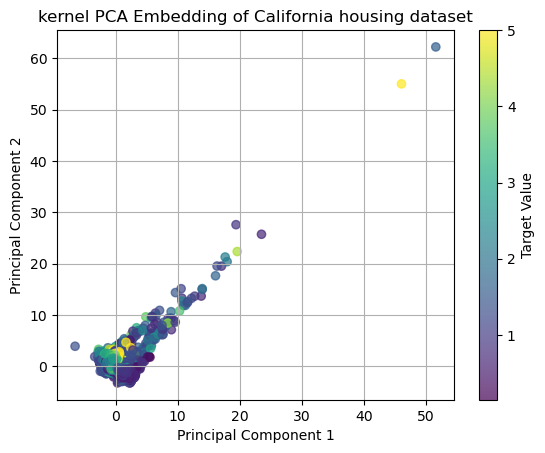

In [42]:
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Value')  
plt.title("kernel PCA Embedding of California housing dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

## Altri modelli

### Visualize embedding function

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

def visualize_embedding(X_embedded, y, title):
    dim = X_embedded.shape[1]
    if dim not in [2, 3]:
        raise ValueError("Embedding dimension must be 2 or 3 for visualization.")
    
    plt.figure(figsize=(8, 6))
    if dim == 2:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7, edgecolor='k')
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
    else:  # 3D plot
        ax = plt.axes(projection='3d')
        sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2],
                        c=y, cmap='viridis', alpha=0.7, edgecolor='k')
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Subsampling to reduce time

In [49]:
from sklearn.utils import resample

X_sampled, y_sampled = resample(X, y, n_samples=3000, random_state=42)

In [50]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_sampled)

### Parameters grid

In [51]:
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.ensemble import RandomTreesEmbedding

models = {
    'Isomap': (Isomap, {
        'n_components': [2, 3],
        'n_neighbors': [5, 10]  
    }),
    'GaussianRandomProjection': (GaussianRandomProjection, {
        'n_components': [2, 3],
        'eps': [0.1, 0.5]
    }),
    'SparseRandomProjection': (SparseRandomProjection, {
        'n_components': [2, 3],
        'density': [0.1, 0.5]
    }),
    'TruncatedSVD': (TruncatedSVD, {
        'n_components': [2, 3]
    }),
    'KernelPCA': (KernelPCA, {
        'n_components': [2, 3],
        'kernel': ['linear', 'rbf']  
    }),
    'LocallyLinearEmbedding': (LocallyLinearEmbedding, {
        'n_components': [2, 3],
        'n_neighbors': [5, 10],
        'method': ['standard', 'modified']
    }),
}

### Calculating results

Executing -- Isomap...
Mean RMSE: 1.1701 ± 0.0379
Mean R²: -0.0014 ± 0.0081
Isomap R² Score: -0.0014 ± 0.0081


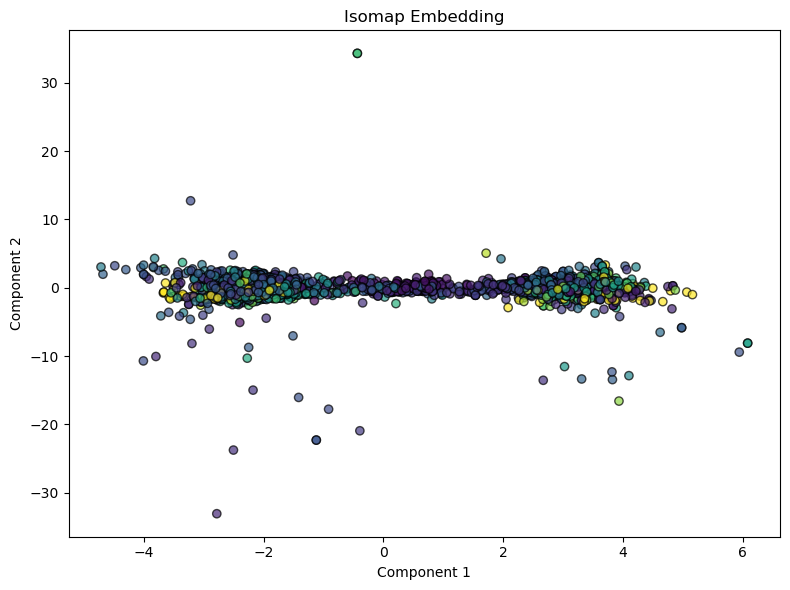

Executing -- GaussianRandomProjection...
Mean RMSE: 0.9100 ± 0.0327
Mean R²: 0.3943 ± 0.0115
GaussianRandomProjection R² Score: 0.3943 ± 0.0115


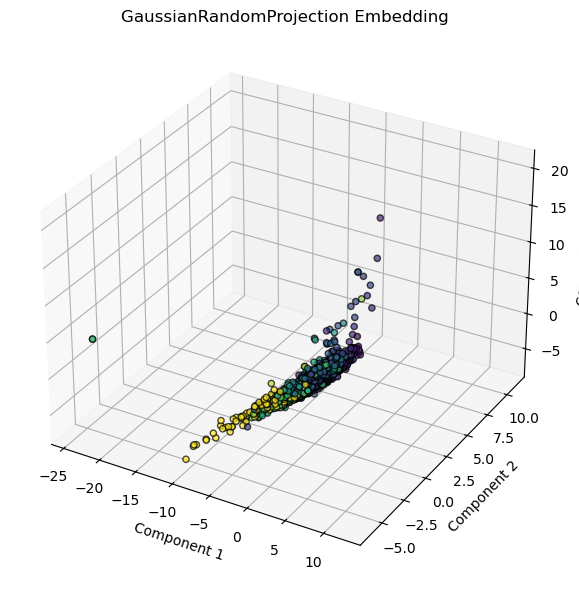

Executing -- SparseRandomProjection...
Mean RMSE: 1.1461 ± 0.0352
Mean R²: 0.0389 ± 0.0252
SparseRandomProjection R² Score: 0.0389 ± 0.0252


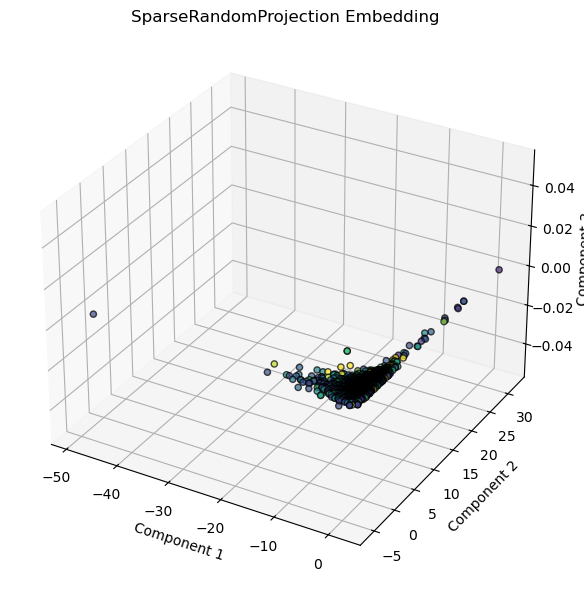

Executing -- TruncatedSVD...
Mean RMSE: 1.1782 ± 0.0410
Mean R²: -0.0181 ± 0.0787
TruncatedSVD R² Score: -0.0181 ± 0.0787


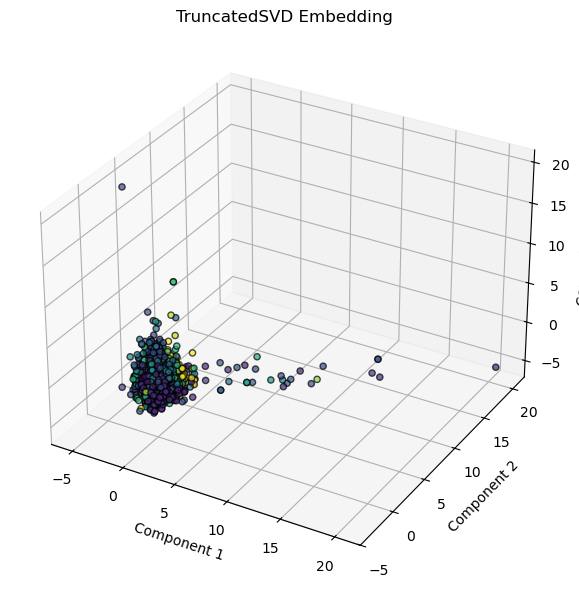

Executing -- KernelPCA...
Mean RMSE: 1.1782 ± 0.0410
Mean R²: -0.0181 ± 0.0787
KernelPCA R² Score: -0.0181 ± 0.0787


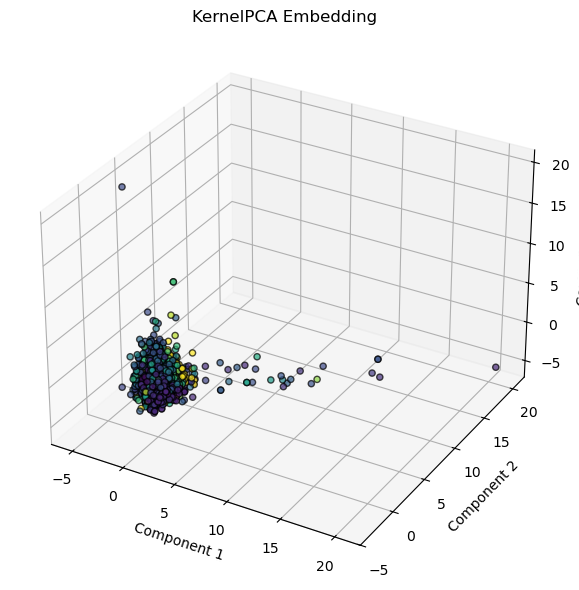

Executing -- LocallyLinearEmbedding...
Mean RMSE: 1.1650 ± 0.0401
Mean R²: 0.0075 ± 0.0011
LocallyLinearEmbedding R² Score: 0.0075 ± 0.0011


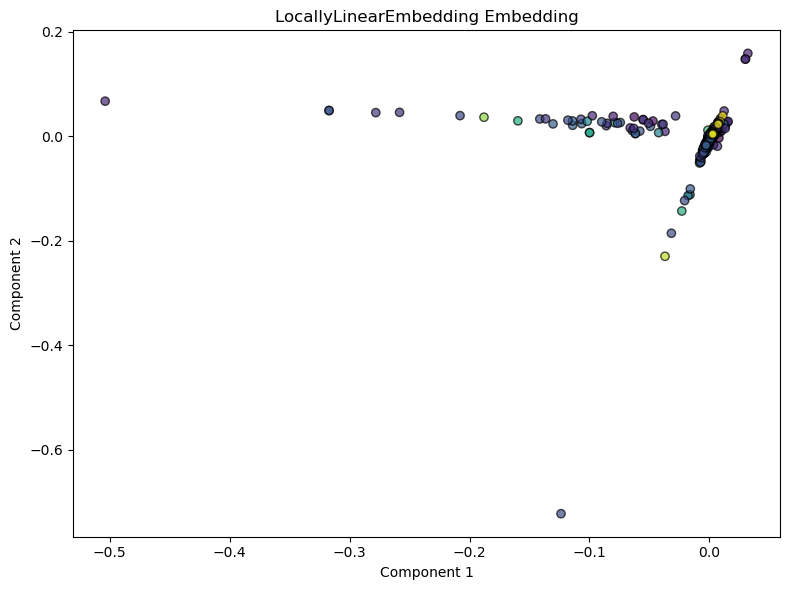

In [52]:
results = []

for model_name, (model, param_grid) in models.items():
    print(f"Executing -- {model_name}...")
    
    best_params, best_score = best_manifold_regression(X_std, y_sampled, 
                                                         model, param_grid, 
                                                         n_iter=1)

    if best_params is None:
        print(f"No valid parameters found for {model_name}, skipping...")
        continue  # skip this model
    
    X_embedded = model(**best_params).fit_transform(X_std)
    
    r2, std_dev = evaluate_with_kfold(model_rr, X_embedded, y_sampled)
    results.append((model_name, r2, std_dev, best_params)) 

    print(f"{model_name} R² Score: {r2:.4f} ± {std_dev:.4f}")
    visualize_embedding(X_embedded, y_sampled, f"{model_name} Embedding")

### Ranking methods

In [53]:
results.sort(key=lambda x: x[1], reverse=True)
print("Models ranked by accuracy:")
for model_name, accuracy, std_dev, params in results:
    print(f"{model_name}: {accuracy:.4f} ± {std_dev:.4f} - Params: {params}")

Models ranked by accuracy:
GaussianRandomProjection: 0.3943 ± 0.0115 - Params: {'n_components': 3, 'eps': 0.1}
SparseRandomProjection: 0.0389 ± 0.0252 - Params: {'n_components': 3, 'density': 0.1}
LocallyLinearEmbedding: 0.0075 ± 0.0011 - Params: {'n_neighbors': 10, 'n_components': 2, 'method': 'standard'}
Isomap: -0.0014 ± 0.0081 - Params: {'n_neighbors': 10, 'n_components': 2}
KernelPCA: -0.0181 ± 0.0787 - Params: {'n_components': 3, 'kernel': 'linear'}
TruncatedSVD: -0.0181 ± 0.0787 - Params: {'n_components': 3}
